# Stock Sentiment Analysis from Tweets
1. Data Exploration
2. Preprocessing
3. Feature Engineering (BoW, Word2Vec, DistilBERT embeddings)
4. Modeling (KNN, Logistic Regression, XGBoost, LSTM)

---
## Imports
---

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Text preprocessing
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from langdetect import detect

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Deep Learning
import torch
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel, pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---
## Data Loading and Initial Exploration
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load train data
train_path = "/content/drive/MyDrive/Project Data/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


---
## Data Exploration and Visualization
---
   - Dataset contains 9543 training samples with 3 sentiment classes
   - Sentiment distribution is unbalanced with the majority class 2 (Neutral)
   - The owerwhelming majority of Tweets in corpus is in English

Missing values in training data:
text     0
label    0
dtype: int64


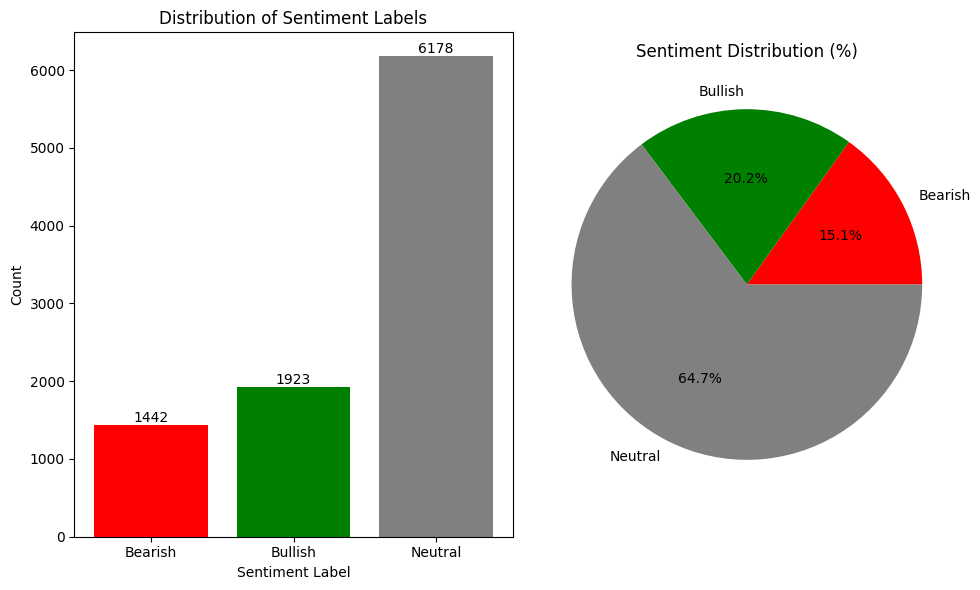

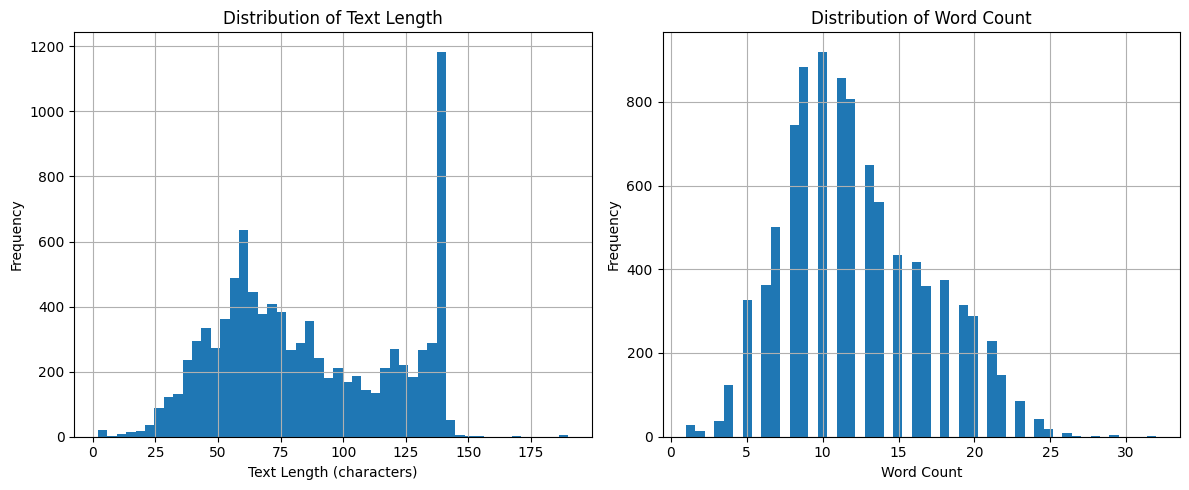


=== Sample Tweets by Sentiment ===

Bearish (Label 0):
1. $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT...
2. $CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2Re...
3. $CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb...

Bullish (Label 1):
1. $ALTG: Dougherty & Company starts at Buy...
2. $AMD - AMD's Navi shows strong adoption - BofA https://t.co/WnCksfl1gX...
3. $ANCUF: BMO Capital Markets ups to Outperform...

Neutral (Label 2):
1. $LB - MKM Partners puts a number on Victoria's Secret https://t.co/VSzHLqLBgE...
2. $WING - Baird returns to Wingstop bull camp https://t.co/KfPaweOVgo...
3. Analysts React To FCC Decision On Intelsat C-Band Spectrum Auction...


In [3]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

# Label distribution
plt.figure(figsize=(10, 6))
label_counts = train_df['label'].value_counts().sort_index()
label_names = ['Bearish', 'Bullish', 'Neutral']

plt.subplot(1, 2, 1)
bars = plt.bar(label_counts.index, label_counts.values, color=['red', 'green', 'gray'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.xticks(label_counts.index, label_names)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_names, autopct='%1.1f%%',
        colors=['red', 'green', 'gray'])
plt.title('Sentiment Distribution (%)')
plt.tight_layout()
plt.show()

# Text length analysis
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_df['text_length'].hist(bins=50)
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')

plt.subplot(1, 2, 2)
train_df['word_count'].hist(bins=50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.tight_layout()
plt.show()

# Sample tweets by sentiment
print("\n=== Sample Tweets by Sentiment ===")
for label, name in enumerate(label_names):
    print(f"\n{name} (Label {label}):")
    samples = train_df[train_df['label'] == label]['text'].head(3)
    for i, tweet in enumerate(samples, 1):
        print(f"{i}. {tweet[:100]}...")

---
## Language Detection and Analysis
---

Language distribution in sample:
language
en    922
ca     16
de     12
fr     11
es     10
sv      7
da      4
no      3
pt      3
pl      3
Name: count, dtype: int64


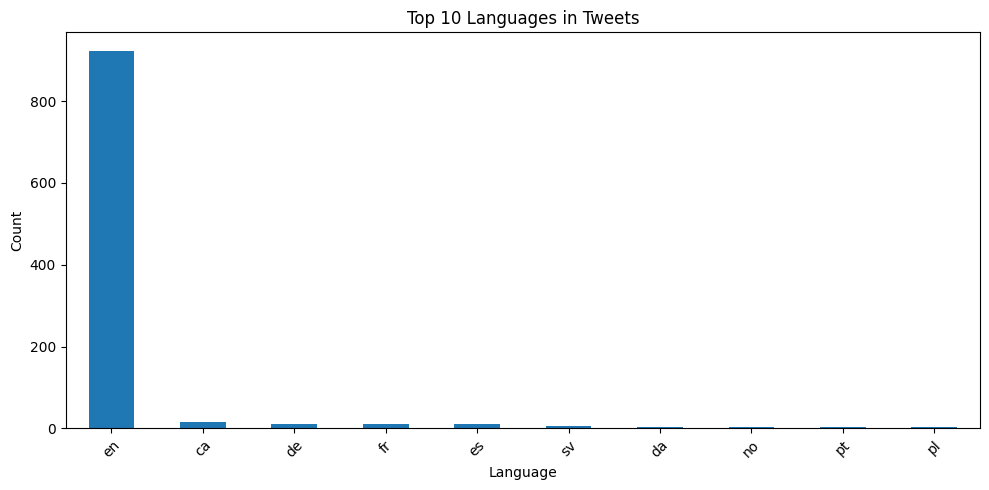

In [4]:
# Professor's hint: Tweets might not all be in English
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Sample language detection (on subset due to time)
sample_size = min(1000, len(train_df))
train_df_sample = train_df.sample(n=sample_size, random_state=42)
train_df_sample['language'] = train_df_sample['text'].apply(detect_language)

# Language distribution
lang_dist = train_df_sample['language'].value_counts()
print("Language distribution in sample:")
print(lang_dist.head(10))

# Visualize language distribution
plt.figure(figsize=(10, 5))
lang_dist.head(10).plot(kind='bar')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Top 10 Languages in Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## Text Preprocessing
---
Preprocessing Techniques Applied:
   - URL and mention removal
   - Lowercasing and punctuation removal
   - Stopword removal
   - Lemmatization
   - Special character handling

In [5]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text,
                   remove_stopwords=True,
                   remove_urls=True,
                   remove_mentions=True,
                   remove_hashtags=False,
                   remove_numbers=True,
                   remove_punctuation=True,
                   lowercase=True,
                   lemmatize=True,
                   stem=False):
    """
    Comprehensive text preprocessing function
    """
    # Convert to string
    text = str(text)

    # Lowercase
    if lowercase:
        text = text.lower()

    # Remove URLs
    if remove_urls:
        text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove mentions
    if remove_mentions:
        text = re.sub(r'@\w+', '', text)

    # Remove hashtags (optional - might contain sentiment info)
    if remove_hashtags:
        text = re.sub(r'#\w+', '', text)

    # Remove numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    if remove_punctuation:
        text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization or Stemming
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    elif stem:
        tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

In [ ]:
# Apply preprocessing
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)

print("\nPreprocessing examples:")
for i in range(3):
    print(f"\nOriginal: {train_df['text'].iloc[i][:100]}...")
    print(f"Processed: {train_df['processed_text'].iloc[i][:100]}...")

Preprocessing training data...

Preprocessing examples:

Original: $BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT...
Processed: bynd jpmorgan reel expectation beyond meat...

Original: $CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2Re...
Processed: ccl rcl nomura point booking weakness carnival royal caribbean...

Original: $CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb...
Processed: cx cemex cut credit suisse j p morgan weak building outlook...


---
## Word Cloud Visualization
---

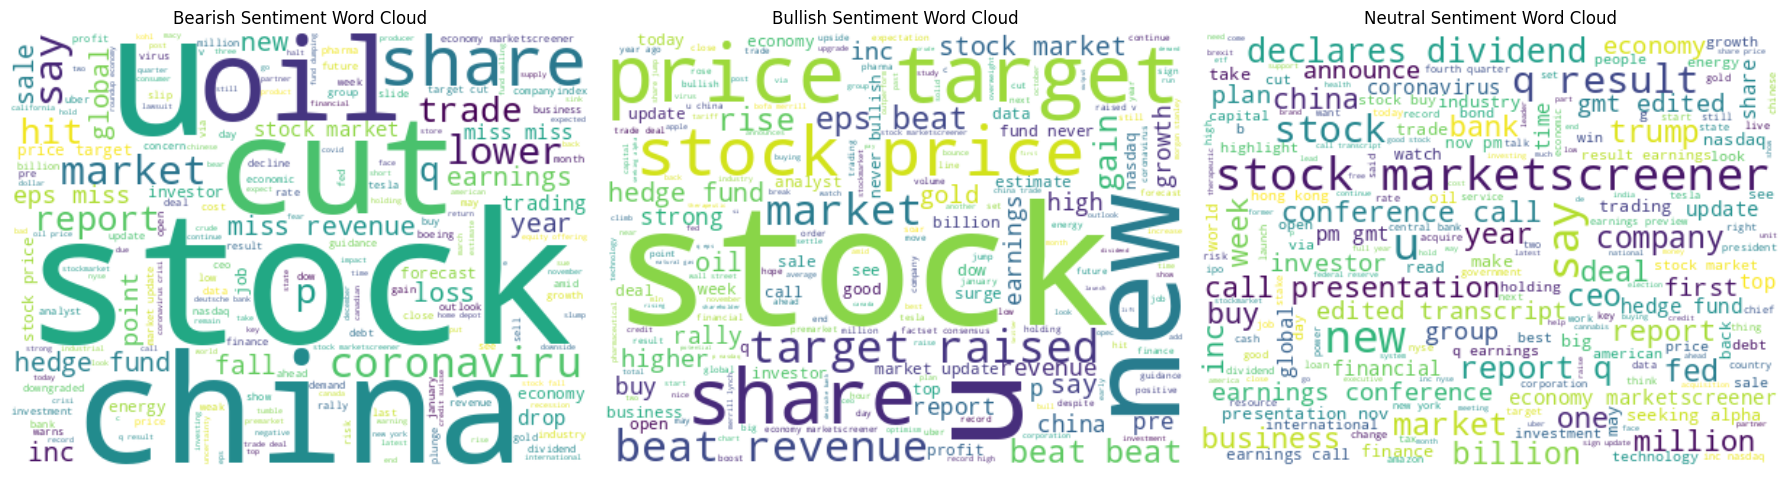

In [7]:
# Generate word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for label, (name, ax) in enumerate(zip(label_names, axes)):
    text = ' '.join(train_df[train_df['label'] == label]['processed_text'].values)
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{name} Sentiment Word Cloud')
    ax.axis('off')

plt.tight_layout()
plt.show()

---
## Corpus Split (Train/Validation)
---

In [8]:
# Split the training data into train and validation sets
X = train_df['text']  # Use original text for transformer models
y = train_df['label']

# Stratified split to maintain label distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"\nLabel distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nLabel distribution in validation set:")
print(y_val.value_counts().sort_index())

Training set size: 7634
Validation set size: 1909

Label distribution in training set:
label
0    1154
1    1538
2    4942
Name: count, dtype: int64

Label distribution in validation set:
label
0     288
1     385
2    1236
Name: count, dtype: int64


---
## Feature Engineering
---
Feature Engineering Methods:
   - Bag of Words (BoW)
   - Word2Vec embeddings
   - DistilBERT transformer embeddings

---
### Bag of Words (BoW)
---

In [9]:
# BoW with preprocessed text
X_train_processed = train_df.loc[X_train.index, 'processed_text']
X_val_processed = train_df.loc[X_val.index, 'processed_text']

# Create BoW features
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train_processed)
X_val_bow = bow_vectorizer.transform(X_val_processed)

print(f"BoW feature shape - Train: {X_train_bow.shape}, Val: {X_val_bow.shape}")

BoW feature shape - Train: (7634, 5000), Val: (1909, 5000)


---
### Word2Vec Embeddings
---

In [10]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
print("Loading Word2Vec model...")
w2v_model = api.load('glove-twitter-50')

def get_word2vec_features(texts, model, dim=50):
    """Convert texts to Word2Vec features by averaging word embeddings"""
    features = []
    for text in tqdm(texts, desc="Creating Word2Vec features"):
        words = text.split()
        vectors = []
        for word in words:
            if word in model:
                vectors.append(model[word])
        if vectors:
            features.append(np.mean(vectors, axis=0))
        else:
            features.append(np.zeros(dim))
    return np.array(features)

# Create Word2Vec features
X_train_w2v = get_word2vec_features(X_train_processed, w2v_model)
X_val_w2v = get_word2vec_features(X_val_processed, w2v_model)

print(f"Word2Vec feature shape - Train: {X_train_w2v.shape}, Val: {X_val_w2v.shape}")

Loading Word2Vec model...
[==================================================] 100.0% 199.5/199.5MB downloaded


Creating Word2Vec features: 100%|██████████| 1909/1909 [00:00<00:00, 22237.51it/s]

Word2Vec feature shape - Train: (7634, 50), Val: (1909, 50)


---
### DistilBERT Embeddings (Transformer)
---


In [11]:
# Load DistilBERT model and tokenizer
print("Loading DistilBERT...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

def get_distilbert_embeddings(texts, tokenizer, model, batch_size=16):
    """Extract CLS token embeddings from DistilBERT"""
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting DistilBERT embeddings"):
        batch_texts = texts[i:i+batch_size].tolist()

        # Tokenize and pad
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,  # Limit for efficiency
            return_tensors='pt'
        )

        # Move to device
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        # Get embeddings
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Use CLS token embedding (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)

    return np.array(embeddings)

# Extract DistilBERT embeddings
X_train_bert = get_distilbert_embeddings(X_train, tokenizer, model)
X_val_bert = get_distilbert_embeddings(X_val, tokenizer, model)

print(f"DistilBERT feature shape - Train: {X_train_bert.shape}, Val: {X_val_bert.shape}")

Loading DistilBERT...
Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Extracting DistilBERT embeddings: 100%|██████████| 120/120 [02:24<00:00,  1.21s/it]

DistilBERT feature shape - Train: (7634, 768), Val: (1909, 768)


---
## Classification Models
---
Models Implemented:
   - KNN (baseline)
   - Logistic Regression with BERT embeddings
   - XGBoost with BERT embeddings
   - Multi-layer Bidirectional LSTM

---
### Baseline: KNN Classifier
---


=== KNN with BoW ===
Accuracy: 0.6957
Precision: 0.6750
Recall: 0.6957
F1-Score: 0.6346

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.61      0.12      0.21       288
     Bullish       0.62      0.27      0.38       385
     Neutral       0.71      0.96      0.81      1236

    accuracy                           0.70      1909
   macro avg       0.65      0.45      0.47      1909
weighted avg       0.68      0.70      0.63      1909



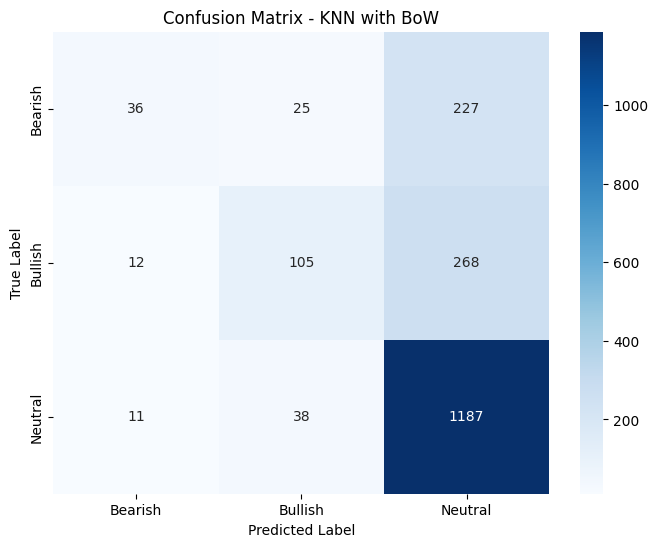


=== KNN with Word2Vec ===
Accuracy: 0.6925
Precision: 0.6809
Recall: 0.6925
F1-Score: 0.6858

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.43      0.36      0.39       288
     Bullish       0.48      0.47      0.48       385
     Neutral       0.80      0.84      0.82      1236

    accuracy                           0.69      1909
   macro avg       0.57      0.56      0.56      1909
weighted avg       0.68      0.69      0.69      1909



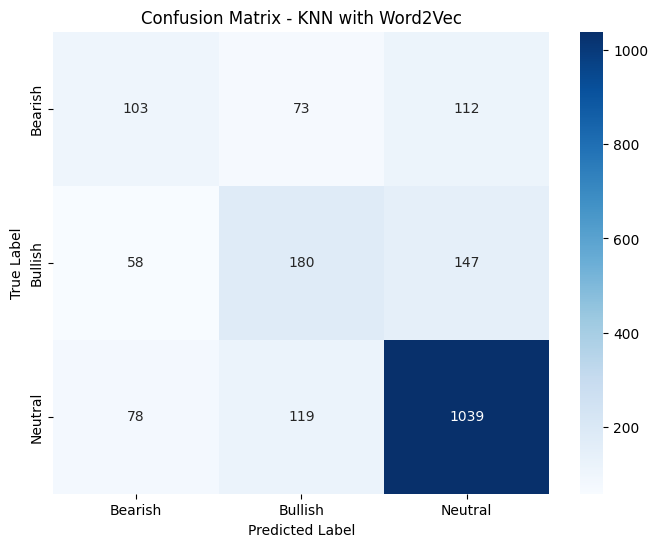


=== KNN with DistilBERT ===
Accuracy: 0.7229
Precision: 0.7255
Recall: 0.7229
F1-Score: 0.7241

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.46      0.47      0.46       288
     Bullish       0.51      0.53      0.52       385
     Neutral       0.85      0.84      0.85      1236

    accuracy                           0.72      1909
   macro avg       0.61      0.61      0.61      1909
weighted avg       0.73      0.72      0.72      1909



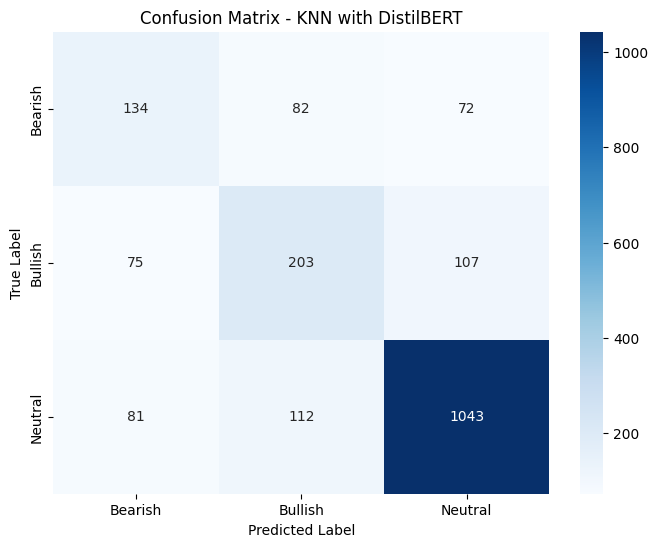

(KNeighborsClassifier(),
 0.7228915662650602,
 0.7254526482033983,
 0.7228915662650602,
 0.7241287819703538)

In [12]:
# KNN with different feature sets
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name, feature_name):
    """Train and evaluate a model"""
    print(f"\n=== {model_name} with {feature_name} ===")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)

    # Evaluate
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=label_names))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix - {model_name} with {feature_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model, accuracy, precision, recall, f1

# KNN with BoW
knn_bow = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_bow, X_train_bow, X_val_bow, y_train, y_val, "KNN", "BoW")

# KNN with Word2Vec
knn_w2v = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_w2v, X_train_w2v, X_val_w2v, y_train, y_val, "KNN", "Word2Vec")

# KNN with DistilBERT
knn_bert = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_bert, X_train_bert, X_val_bert, y_train, y_val, "KNN", "DistilBERT")

---
### Logistic Regression with DistilBERT
---


=== Logistic Regression with DistilBERT ===
Accuracy: 0.7910
Precision: 0.7824
Recall: 0.7910
F1-Score: 0.7834

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.67      0.54      0.60       288
     Bullish       0.71      0.60      0.65       385
     Neutral       0.83      0.91      0.87      1236

    accuracy                           0.79      1909
   macro avg       0.74      0.68      0.70      1909
weighted avg       0.78      0.79      0.78      1909



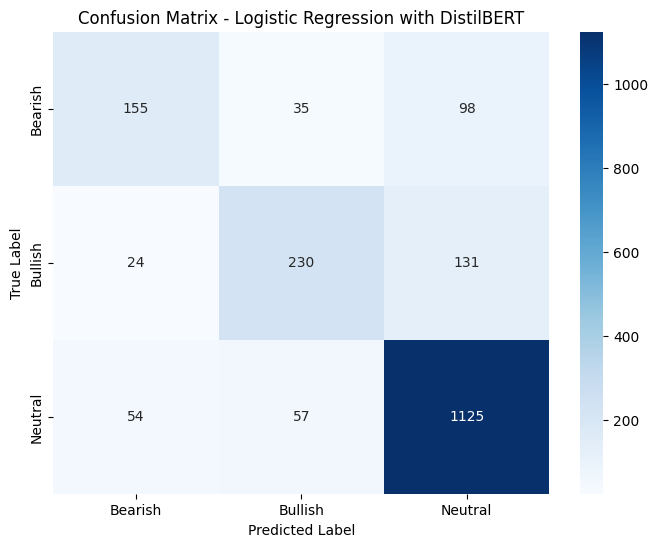

In [13]:
# Logistic Regression with DistilBERT embeddings
lr_bert = LogisticRegression(max_iter=1000, random_state=42)
lr_model, lr_acc, lr_prec, lr_rec, lr_f1 = evaluate_model(
    lr_bert, X_train_bert, X_val_bert, y_train, y_val,
    "Logistic Regression", "DistilBERT"
)

---
### XGBoost with DistilBERT
---


=== XGBoost with DistilBERT ===
Accuracy: 0.7768
Precision: 0.7661
Recall: 0.7768
F1-Score: 0.7555

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.71      0.38      0.50       288
     Bullish       0.71      0.50      0.59       385
     Neutral       0.80      0.95      0.87      1236

    accuracy                           0.78      1909
   macro avg       0.74      0.61      0.65      1909
weighted avg       0.77      0.78      0.76      1909



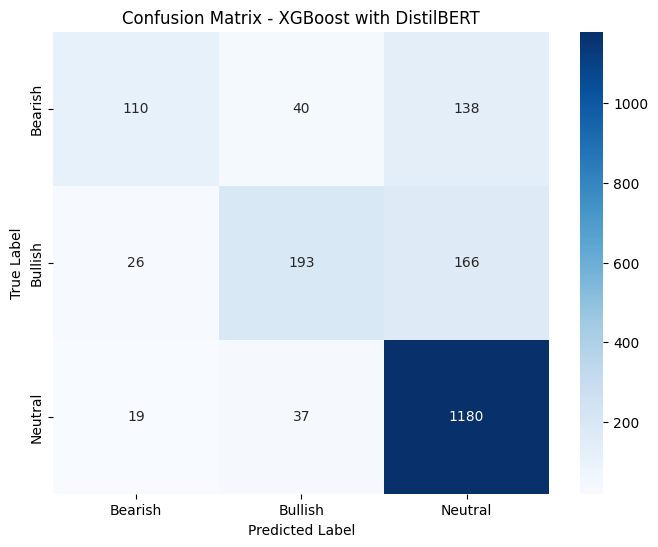

In [14]:
# XGBoost with DistilBERT embeddings
xgb_bert = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model, xgb_acc, xgb_prec, xgb_rec, xgb_f1 = evaluate_model(
    xgb_bert, X_train_bert, X_val_bert, y_train, y_val,
    "XGBoost", "DistilBERT"
)

---
### LSTM Model Implementation
---

Padded sequence shape - Train: (7634, 100), Val: (1909, 100)
One-hot encoded target shape - Train: (7634, 3), Val: (1909, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.6408 - loss: 0.8881

239/239 ━━━━━━━━━━━━━━━━━━━━ 196s 753ms/step - accuracy: 0.6410 - loss: 0.8877 - val_accuracy: 0.7166 - val_loss: 0.6730
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.7778 - loss: 0.5263

239/239 ━━━━━━━━━━━━━━━━━━━━ 175s 732ms/step - accuracy: 0.7778 - loss: 0.5263 - val_accuracy: 0.7397 - val_loss: 0.6410
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8403 - loss: 0.3840

239/239 ━━━━━━━━━━━━━━━━━━━━ 205s 746ms/step - accuracy: 0.8403 - loss: 0.3840 - val_accuracy: 0.7569 - val_loss: 0.6804
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9192 - loss: 0.2373

239/239 ━━━━━━━━━━━━━━━━━━━━ 203s 752ms/step - accuracy: 0.9192 - loss: 0.2373 - val_accuracy: 0.7685 - val_loss: 0.7869
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 201s 747ms/step - accuracy: 0.9560 - loss: 0.1464 - val_accuracy: 0.7585 - val_loss: 0.9109


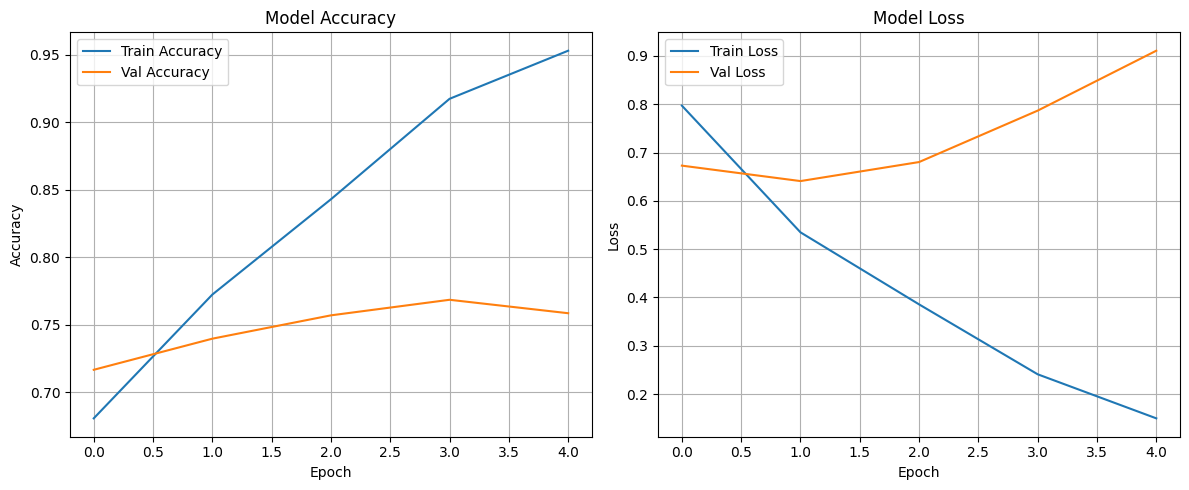

60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step

=== LSTM Model Performance ===
Accuracy: 0.7397
Precision: 0.7078
Recall: 0.7397
F1-Score: 0.7179

Classification Report:
              precision    recall  f1-score   support

     Bearish       0.39      0.21      0.27       288
     Bullish       0.58      0.56      0.57       385
     Neutral       0.82      0.92      0.87      1236

    accuracy                           0.74      1909
   macro avg       0.60      0.56      0.57      1909
weighted avg       0.71      0.74      0.72      1909



In [15]:


# Prepare data for LSTM
max_length = 100  # Maximum sequence length

# Tokenize and create sequences
tokenizer_lstm = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer_lstm.fit_on_texts(X_train_processed)

# Convert texts to sequences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train_processed)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val_processed)

# Pad sequences (Professor's hint: pad after tokenization)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# One-hot encode targets (Professor's hint)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

print(f"Padded sequence shape - Train: {X_train_pad.shape}, Val: {X_val_pad.shape}")
print(f"One-hot encoded target shape - Train: {y_train_cat.shape}, Val: {y_val_cat.shape}")

# Build LSTM model (with multiple LSTM layers as suggested)
def build_lstm_model(vocab_size, embedding_dim=128, max_length=100):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)),  # First LSTM layer
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),   # Second LSTM layer
        Bidirectional(LSTM(32, dropout=0.2)),                          # Third LSTM layer
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train LSTM model
vocab_size = len(tokenizer_lstm.word_index) + 1
lstm_model = build_lstm_model(vocab_size, max_length=max_length)
lstm_model.summary()

# Train with early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_accuracy')

history = lstm_model.fit(
    X_train_pad, y_train_cat,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Plot training history (Professor's hint: find sweet spot of epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate LSTM
y_pred_lstm_prob = lstm_model.predict(X_val_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

print("\n=== LSTM Model Performance ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lstm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lstm, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_lstm, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lstm, target_names=label_names))